In [ ]:
import os
import json
import torch
import torchvision
from transformers import DetrImageProcessor, DetrForObjectDetection, TrainingArguments, Trainer

# =======================
# 0.  PATHS 
# =======================

ANN_PATH = r".\Data\annotations_DETR\merged_annotations0-460.json"
IMG_DIR  = r".\Data\images_before"

RUN_NAME = "detr-finetuned-floorplans"
OUTPUT_DIR = os.path.join(r".\Models", RUN_NAME)

# צור תיקייה אם לא קיימת
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("ANN_PATH:", ANN_PATH)
print("IMG_DIR:", IMG_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)

# =======================
# 1. Device
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type == "cuda":
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")

# =======================
# 2. Load COCO json + build id_map to 0..N-1
# =======================
with open(ANN_PATH, "r", encoding="utf-8") as f:
    coco_json = json.load(f)

cats = coco_json["categories"]
cat_ids = sorted([c["id"] for c in cats])
id_map = {old_id: new_id for new_id, old_id in enumerate(cat_ids)}  # old -> new

print("Category IDs in categories:", cat_ids)
ann_cat_ids = sorted({a["category_id"] for a in coco_json["annotations"]})
print("Unique category IDs in annotations:", ann_cat_ids)

id2label = {id_map[c["id"]]: c["name"] for c in cats}   # new_id -> name
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)
print(f"✅ Found {num_labels} classes (0..{num_labels-1}): {id2label}")

# =======================
# 3. Processor (speed: resize smaller)
# =======================
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50",
    size={"shortest_edge": 512, "longest_edge": 512}  
)

# =======================
# 4. Dataset
# =======================
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, processor, id_map):
        super().__init__(img_folder, ann_file)
        self.processor = processor
        self.id_map = id_map

        # Fix file_name paths if COCO json has subfolders inside file_name
        fixed = 0
        for img_id in self.coco.imgs:
            fn = self.coco.imgs[img_id]["file_name"]
            base = os.path.basename(fn)
            if fn != base:
                self.coco.imgs[img_id]["file_name"] = base
                fixed += 1
        if fixed:
            print(f"🔧 Auto-fixed file_name for {fixed} images.")

        # Sanity print
        for i in range(min(5, len(self.ids))):
            img_id = self.ids[i]
            anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
            print(f"{i} num_objects: {len(anns)}")

    def __getitem__(self, idx):
        img, anns = super().__getitem__(idx)
        image_id = self.ids[idx]

        cleaned = []
        for a in anns:
            if a.get("iscrowd", 0) == 1:
                continue
            cid = a["category_id"]
            if cid not in self.id_map:
                continue
            a = dict(a)
            a["category_id"] = self.id_map[cid]
            cleaned.append(a)

        target = {"image_id": image_id, "annotations": cleaned}
        enc = self.processor(images=img, annotations=target, return_tensors="pt")

        return {
            "pixel_values": enc["pixel_values"].squeeze(0),
            "labels": enc["labels"][0],
        }

train_dataset = CocoDetection(
    img_folder=IMG_DIR,
    ann_file=ANN_PATH,
    processor=processor,
    id_map=id_map
)

# =======================
# 5. Collate
# =======================
def collate_fn(batch):
    pixel_values = [x["pixel_values"] for x in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [x["labels"] for x in batch]
    return {
        "pixel_values": encoding["pixel_values"],
        "pixel_mask": encoding["pixel_mask"],
        "labels": labels
    }

# =======================
# 6. Model
# =======================
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    ignore_mismatched_sizes=True,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

# =======================
# 7. Training args (fast + stable on Windows)
# =======================
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,   # חשוב: שלא יתקע אם כבר יש תיקייה
    per_device_train_batch_size=4,
    num_train_epochs=50,
    learning_rate=1e-4,
    weight_decay=1e-4,
    save_total_limit=2,
    logging_steps=25,
    fp16=torch.cuda.is_available(),
    remove_unused_columns=False,
    report_to="none",
    save_strategy="epoch",

    # IMPORTANT for Windows stability:
    dataloader_num_workers=0,
    dataloader_pin_memory=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
)

print("Trainer device:", trainer.args.device)
print("Model device:", next(model.parameters()).device)

print("🚀 Starting training...")
trainer.train()

trainer.save_model(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)
print(f"🎉 Done! Saved to: {OUTPUT_DIR}")


<>:13: SyntaxWarning: invalid escape sequence '\i'
<>:13: SyntaxWarning: invalid escape sequence '\i'
C:\Users\adiha\AppData\Local\Temp\ipykernel_31704\3512195537.py:13: SyntaxWarning: invalid escape sequence '\i'
  IMG_DIR  = os.path.join(BASE_DIR, "synthetic_dataset\images_before")
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ANN_PATH: C:\Users\adiha\Desktop\GENAI\annotations\merged_annotations0-460.json
IMG_DIR: C:\Users\adiha\Desktop\GENAI\synthetic_dataset\images_before
OUTPUT_DIR: C:\Users\adiha\Desktop\GENAI\Model\detr-finetuned-floorplans
🖥️ Using device: cuda
🚀 GPU: NVIDIA GeForce RTX 4060
Category IDs in categories: [1, 2, 3, 4, 5, 6]
Unique category IDs in annotations: [1, 2, 3, 4, 5, 6]
✅ Found 6 classes (0..5): {0: 'sink', 1: '1stdoor', 2: '2sdoor', 3: 'toilet', 4: 'closet', 5: 'stove'}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
0 num_objects: 16
1 num_objects: 11
2 num_objects: 15
3 num_objects: 9
4 num_objects: 21


c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2400: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model,

Trainer device: cuda:0
Model device: cuda:0
🚀 Starting training...


Step,Training Loss
25,3.947600
50,2.821900
75,2.738600
100,2.755300
125,2.937000
150,2.477500
175,2.522000
200,2.538400
225,2.298100
250,2.280100


🎉 Done! Saved to: C:\Users\adiha\Desktop\GENAI\Model\detr-finetuned-floorplans


Using device: cuda

Detected objects:
✔ toilet: 0.722 | box=[322.51, 85.96, 357.31, 113.02]
✔ 1stdoor: 0.990 | box=[263.47, 251.24, 308.03, 298.14]
✔ 1stdoor: 0.987 | box=[193.04, 170.35, 241.26, 215.72]
✔ 1stdoor: 0.981 | box=[282.45, 413.96, 330.01, 455.26]
✔ closet: 0.952 | box=[383.63, 371.29, 455.25, 403.27]
✔ closet: 0.965 | box=[319.29, 228.91, 353.22, 291.53]
✔ 1stdoor: 0.943 | box=[572.95, 163.67, 628.08, 206.52]
✔ 1stdoor: 0.959 | box=[264.38, 360.56, 309.73, 409.7]
✔ 2sdoor: 0.777 | box=[568.91, 163.21, 658.81, 198.12]
✔ sink: 0.803 | box=[419.18, 32.83, 457.18, 58.17]
✔ closet: 0.869 | box=[488.18, 16.76, 523.55, 47.12]
✔ 1stdoor: 0.990 | box=[253.95, 120.94, 297.9, 170.92]
✔ 1stdoor: 0.977 | box=[166.99, 78.28, 212.96, 116.25]
✔ closet: 0.905 | box=[58.76, 130.86, 137.29, 162.93]
✔ closet: 0.917 | box=[129.02, 132.73, 170.82, 164.85]
✔ sink: 0.737 | box=[246.58, 13.99, 284.39, 39.86]
✔ closet: 0.758 | box=[379.82, 46.66, 413.39, 83.47]


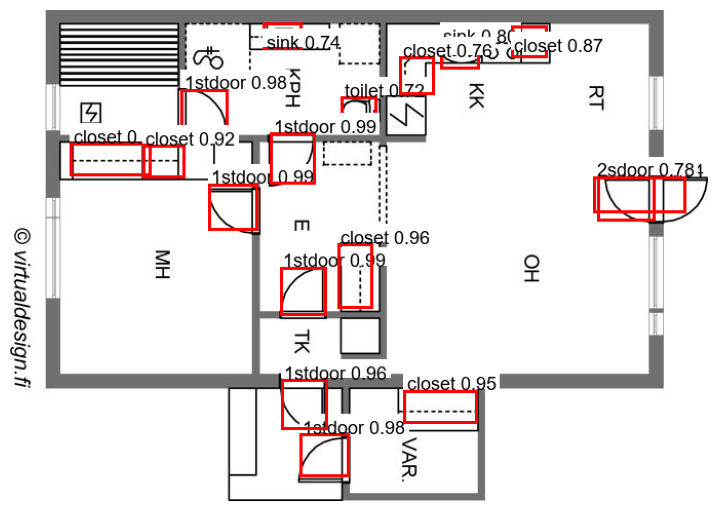

In [18]:
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from transformers import DetrForObjectDetection, DetrImageProcessor

# =======================
# CONFIG
# =======================

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

MODEL_DIR  = os.path.join(PROJECT_ROOT, "Models", "detr-finetuned-floorplans")
IMAGE_PATH = os.path.join(PROJECT_ROOT, "Data", "images_before", "image_053.jpg")
THRESH = 0.7


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =======================
# Load model + processor
# =======================
processor = DetrImageProcessor.from_pretrained(MODEL_DIR)
model = DetrForObjectDetection.from_pretrained(MODEL_DIR).to(device)
model.eval()

# =======================
# Load image
# =======================
image = Image.open(IMAGE_PATH).convert("RGB")
draw = ImageDraw.Draw(image)

# =======================
# Font 
# =======================
FONT_SIZE = 18
try:
    font = ImageFont.truetype("arial.ttf", FONT_SIZE)
except:
    font = ImageFont.load_default()

# =======================
# Preprocess
# =======================
inputs = processor(images=image, return_tensors="pt").to(device)

# =======================
# Inference
# =======================
with torch.no_grad():
    outputs = model(**inputs)

# =======================
# Post-process
# =======================
target_sizes = torch.tensor([image.size[::-1]]).to(device)
results = processor.post_process_object_detection(
    outputs,
    target_sizes=target_sizes,
    threshold=THRESH
)[0]

# =======================
# Draw results
# =======================
print("\nDetected objects:")
if len(results["scores"]) == 0:
    print("❌ No detections above threshold")
else:
    for score, label, box in zip(
        results["scores"],
        results["labels"],
        results["boxes"]
    ):
        label_name = model.config.id2label[label.item()]
        score = score.item()
        box = [round(i, 2) for i in box.tolist()]

        print(f"✔ {label_name}: {score:.3f} | box={box}")

        # ---- Draw bounding box ----
        draw.rectangle(box, outline="red", width=3)

        # ---- Text ----
        text = f"{label_name} {score:.2f}"
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        x0, y0 = box[0], box[1]

        # Prefer text above box, fallback inside
        text_y = y0 - text_height - 6
        if text_y < 0:
            text_y = y0 + 6

        # Background rectangle
        draw.rectangle(
            [x0, text_y, x0 + text_width + 6, text_y + text_height + 4],
            fill="white"
        )

        # Text itself
        draw.text(
            (x0 + 3, text_y + 2),
            text,
            fill="black",
            font=font
        )

# =======================
# Show image
# =======================
plt.figure(figsize=(9, 9))
plt.imshow(image)
plt.axis("off")
plt.show()
